Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
%matplotlib inline

# Bayesian linear classifiers

In this example you are going to fit a Bayesian logistic regression model, using two sets of features on data $\mathbf{x} \in \mathbb{R}^2.

The first one is a "simple" set of features, with just the two input features plus an intercept:

$$\begin{align*}
\phi_{\text{simple}}(\mathbf{x}) &= [ 1, x_1, x_2 ]
\end{align*}$$

The second is up to you! For example, you could consider a set of quadratic polynomial features,

$$\begin{align*}
\phi_{\text{quadratic}}(\mathbf{x}) &= [ 1, x_1, x_2, x_1x_2, x_1^2, x_2^2 ].
\end{align*}$$

This example just includes quadratic terms, but you could also include higher order polynomial terms (e.g. $x_1^3, x_2^3$) or completely different features alltogether. It's up to you — but you should be prepared to justify your choice!

You will also fit the model in two different ways:

1. MAP estimation (penalized maximum likelihood)
2. Laplace approximation (a Gaussian approximate posterior, centered at the mode)

Here is a synthetic dataset that we'll be working with (plotting the training set only):

C:\Users\44774\AppData\Local\Temp\ipykernel_26428\14187256.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X_train, y_train, X_test, y_test = torch.load("data.pt")


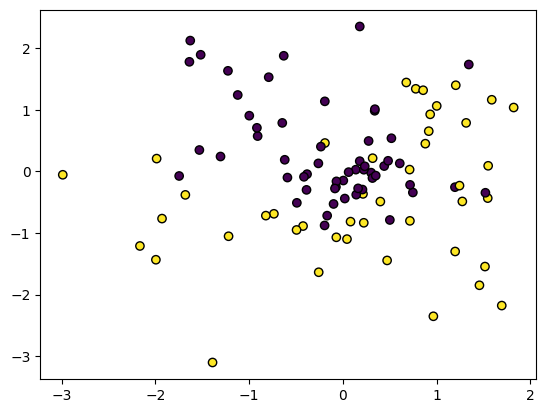

In [49]:
X_train, y_train, X_test, y_test = torch.load("data.pt")
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, edgecolors='k');

Here are definitions of two different feature maps, the "simple" one and the "quadratic" one.

They define feature spaces in $\mathbb{R}^3$ and $\mathbb{R}^6$, respectively.

In [50]:
# Simple feature set: only consider the raw input plus an intercept.
def features_simple(X):
    return torch.concat((torch.ones_like(X[:,:1]), X), -1)
# Quadratic feature set: consider all pairwise products of input features.
def features_quadratic(X):
    interactions = X.prod(-1, keepdim=True)
    return torch.concat((torch.ones_like(X[:,:1]), 
                         X, X.pow(2), interactions), -1)

print("Dimension of Phi, `features_simple`:", features_simple(X_train).shape)
print("Dimension of Phi, `features_quadratic`:", features_quadratic(X_train).shape)

Dimension of Phi, `features_simple`: torch.Size([100, 3])
Dimension of Phi, `features_quadratic`: torch.Size([100, 6])


# TASK #1 (3 points): Define the model

The Bayesian logistic regression model we are working with has the form
$$\begin{align*}
\mathbf{w} &\sim \mathcal{N}(0, \sigma^2 \mathbf{I}) \\
\hat y_i &= \mathrm{Logistic}(\mathbf{w}^\top \phi(\mathbf{x}_i)) \\
y_i &\sim \mathrm{Bernoulli}(\hat y_i)
\end{align*}$$
where $i = 1,\dots, N$ and the Logistic function is defined
$$\begin{align*}
\mathrm{Logistic}(z) &= \frac{1}{1 + \exp\{-z\}}.
\end{align*}$$
It's implemented in pytorch as `torch.sigmoid`.

The first step is to define two functions, one to make predictions given a weight vector $\mathbf{w}$ and inputs $\Phi$, and one which computes the log joint probability

$$\log p(\mathbf{y}, \mathbf{w} | \mathbf{\Phi}, \sigma^2).$$

I've done the first one for you.

In [51]:
# This function computes the probabilities of each observation being in class 1.
def predict_probs_MAP(Phi, w):
    """
    Given a "design matrix" Phi, and a point estimate w, compute p(y = 1 | Phi, w)
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    w     : (D,) vector of weights

    OUTPUT:
    y_hat : (N,) vector of probabilities p(y=1 | Phi, w)
    """
    return torch.sigmoid(Phi @ w)

In [52]:
def log_joint(Phi, y, w, sigma=10):
    """
    Compute the joint probability of the data and the latent variables.
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones
    w     : (D,) vector of weights
    sigma : scalar, standard deviation of Gaussian prior distribution p(w).
            Leave this set to sigma=10 for purposes of this exercise

    OUTPUT:
    log_joint : the log probability log p(y, w | Phi, sigma), a torch scalar
        
    """
    # Compute the logistic likelihood log p(y | Phi, w)
    y_hat = torch.sigmoid(Phi @ w)
    
    # Define the Gaussian prior on w (Multivariate Normal distribution)
    prior_dist = dist.MultivariateNormal(
        loc=torch.zeros(w.size(0)),
        covariance_matrix=sigma**2 * torch.eye(w.size(0))
    )
    
    # Define the Bernoulli likelihood for the data y given y_pred (logistic output)
    likelihood_dist = dist.Bernoulli(probs=y_hat)
    
    # Compute the log prior and log likelihood
    log_prior = prior_dist.log_prob(w)
    log_likelihood = likelihood_dist.log_prob(y).sum()
    
    log_joint = log_prior + log_likelihood
    
    return log_joint

In [53]:
# (GRADING)

In [54]:
# (GRADING)

# TASK 2 (5 points): Implement MAP estimation

Now you need to write a function which performs MAP estimation, i.e. penalized maximum likelihood estimation.

This function should find the value $\mathbf{w}_{MAP}$ that maximizes the log joint, i.e.

$$\mathbf{w}_{MAP} = \mathrm{argmax}_{\mathbf{w}}\log p(\mathbf{y}, \mathbf{w} | \mathbf{\Phi}, \sigma^2).$$

To do this, you should **use pytorch autograd tools**. This will involve defining an initial value of the weights, computing a scalar loss function, and calling `.backward()`, and then performing gradient-based optimization. Take a look at the demo notebooks from previous lectures for examples…!

* You **may feel free to use classes from `torch.optim`**. I would suggest the use of `torch.optim.SGD` or `torch.optim.Adagrad`.
* Regardless of how you do this, you will need to decide on a stopping criteria for your optimization routine.
* You will also need to decide on how to set the parameters (learning rate, momentum, anything else!) for your selected optimizer.

Also, **your code should work for ANY features!**. We will test this out on not just the "simple" and "quadratic" features above, but also on your own custom choice of features.

In [55]:
def find_MAP(Phi, y):
    """
    Find the MAP estimate of the log_joint method.
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones


    OUTPUT:
    w      : (D,) vector of optimized weights
    losses : list of losses at each iteration of the optimization algorithm.
             Should be a list of scalars, which can be plotted afterward to
             diagnose convergence.
    """

    # Initialize weights as a tensor of zeros with same number of elements as feature
    weights = torch.zeros(Phi.shape[1]).requires_grad_(True)
    losses = []
    
    # Define optimizer as SGD
    optimizer = torch.optim.SGD([weights], lr=0.05, momentum=0.8)
    
    # Set Number of iterations as stopping criteria
    num_iters = 100

    # Iteratively optimize w
    for i in range(num_iters):
        # Zero the gradients from the previous step
        optimizer.zero_grad()
        
        # Compute the negative log joint probability
        log_joint_val = log_joint(Phi, y, weights)
        loss = -log_joint_val  # Negative since we are minimizing
        
        # Backpropagate to compute gradients
        loss.backward()
        
        # Update the weights
        optimizer.step()
        
        # Store the loss value for diagnostics
        losses.append(loss.item())
    
    return weights.detach(), losses

### The following two cells call `find_MAP` to compute $\mathbf{w}$ for both choices of features.

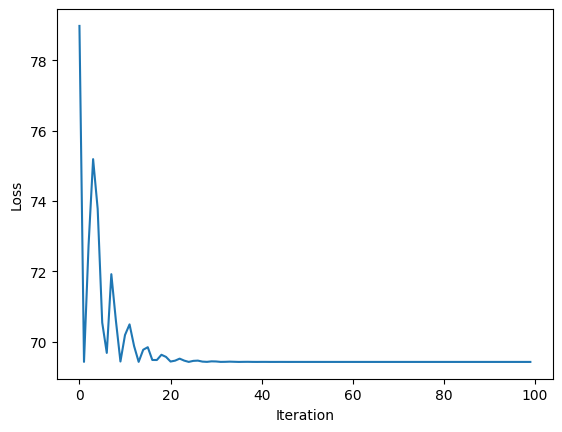

MAP weights for simple features: tensor([-0.2929,  0.4597, -0.8911])


In [56]:
w_MAP_simple, losses = find_MAP(features_simple(X_train), y_train)
plt.plot(losses);
plt.xlabel("Iteration")
plt.ylabel("Loss");
plt.show()

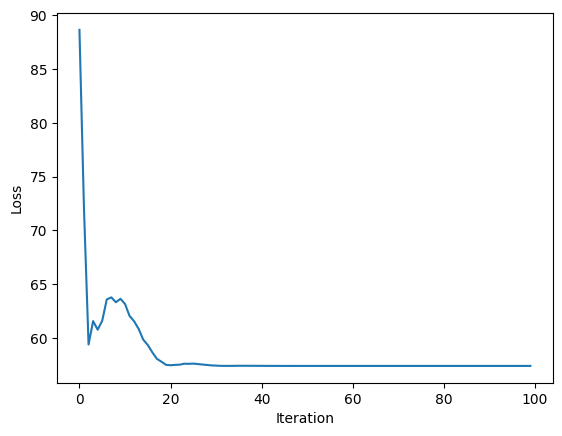

MAP weights for quadratic features: tensor([-2.0297,  0.9647, -1.9974,  1.1846,  0.9053,  1.8550])


In [57]:
w_MAP_quad, losses = find_MAP(features_quadratic(X_train), y_train)
plt.plot(losses);
plt.xlabel("Iteration")
plt.ylabel("Loss");

In [58]:
# (GRADING)

In [59]:
# (GRADING)

## Visualization: The following code visualizes the classifier result

It plots the probability of being one class or the other using a color contour plot.

The decision boundary is a dashed black line.

In [60]:
def plot_boundary(X, y, pred):
    h = 0.2
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = pred(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=.8, levels=np.linspace(0, 1, 8))
    
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
    
    plt.contour(xx, yy, Z, levels=(0.5,), linestyles='dashed');
    
    # Plot the testing points
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())

C:\Users\44774\AppData\Local\Temp\ipykernel_26428\3616446327.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
C:\Users\44774\AppData\Local\Temp\ipykernel_26428\3616446327.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  np.arange(y_min, y_max, h))


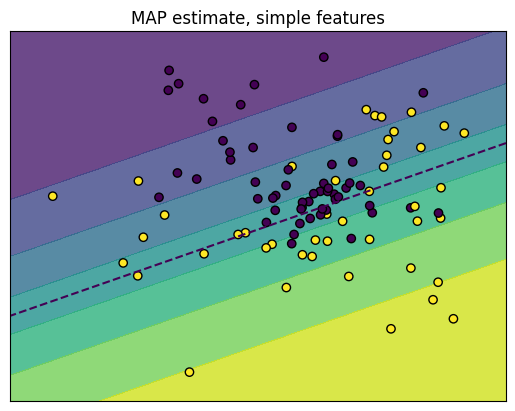

Simple features: training accuracy = 0.68, test accuracy = 0.68


In [61]:
plot_boundary(X_train, y_train, 
              lambda X: predict_probs_MAP(features_simple(X), w_MAP_simple))
plt.title("MAP estimate, simple features")
train_accuracy = (predict_probs_MAP(features_simple(X_train), w_MAP_simple).round() == y_train).float().mean()
test_accuracy = (predict_probs_MAP(features_simple(X_test), w_MAP_simple).round() == y_test).float().mean()
print("Simple features: training accuracy = %0.2f, test accuracy = %0.2f" % (train_accuracy, test_accuracy))

C:\Users\44774\AppData\Local\Temp\ipykernel_26428\3616446327.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
C:\Users\44774\AppData\Local\Temp\ipykernel_26428\3616446327.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  np.arange(y_min, y_max, h))


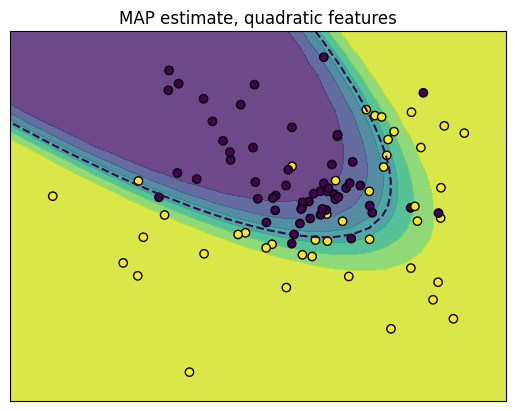

Polynomial features: training accuracy = 0.86, test accuracy = 0.92


In [62]:
plot_boundary(X_train, y_train,
              lambda X: predict_probs_MAP(features_quadratic(X), w_MAP_quad))
plt.title("MAP estimate, quadratic features")
train_accuracy = (predict_probs_MAP(features_quadratic(X_train), w_MAP_quad).round() == y_train).float().mean()
test_accuracy = (predict_probs_MAP(features_quadratic(X_test), w_MAP_quad).round() == y_test).float().mean()
print("Polynomial features: training accuracy = %0.2f, test accuracy = %0.2f" % (train_accuracy, test_accuracy))

# TASK #3 (5 points): Laplace approximation

In the next section, you will fit an approximate posterior over the weights by using the Laplace approximation around the mode $\mathbf{w}_{MAP}$ of the distribution you found above.

This requires completing two functions:

1. `compute_laplace_Cov` takes the data and the MAP estimate, and outputs a covariance matrix defined as the negative inverse Hessian of the log target density. (See the week 4 lecture slides for details on how to compute this!)
2. `predict_bayes` makes predictions on new data points, by approximating $\int p(y | x, w)p(w | \mathcal{D})dw$ when using a Gaussian approximation to $p(w | \mathcal{D})$. In the week 4 lecture slides we discussed three different ways of computing this — it is up to you to decide what method you would prefer, and implement it.

In [63]:
def compute_laplace_Cov(Phi, y, w_MAP, prior_std=10):
    """
    Compute the Laplace approximation of the posterior covariance 
    in a logistic regression setting.
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones
    w_MAP : (D,) vector of optimized weights, at a mode of the target density
    sigma : scalar, standard deviation of Gaussian prior distribution p(w).
            Leave this set to sigma=10 for purposes of this exercise

    OUTPUT:
    Cov : (D, D) posterior covariance matrix estimate defined by the Laplace 
          approximation
    """
    
    # Compute the predicted probabilities at the MAP estimate
    y_hat = torch.sigmoid(Phi @ w_MAP)
    
    # Dimensionality of the feature space
    D = Phi.size(1)
    
    # Initialize the Hessian of the prior, scaled by the prior variance
    H_prior = torch.eye(D) / (prior_std ** 2)
    
    # Accumulate the contributions from the data to the Hessian
    for i in range(Phi.size(0)):
        weight = y_hat[i] * (1 - y_hat[i])
        H_prior += weight * Phi[i].view(D, 1) @ Phi[i].view(1, D)
    
    # Compute the covariance matrix as the inverse of the Hessian
    Cov = torch.inverse(H_prior)
    
    return Cov

In [64]:
def predict_bayes(Phi, w_MAP, Cov):
    """
    Make predictions on new data points using an approximate posterior 
    w ~ MultivariateNormal(w_MAP, Cov)
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    w_MAP : (D,) vector of optimized weights, at a mode of the target density
    Cov   : (D, D) approximate posterior covariance matrix
    
    OUTPUT:
    y_hat : (N,) vector of probabilities p(y=1 | Phi)
    """
    
    # Define the posterior distribution over w
    distribution = torch.distributions.MultivariateNormal(w_MAP, Cov)
    
    num_samples = 10000 
    
    # Initialize an empty list to store predictions
    values = []
    
    # Sample weights from the posterior and compute predictions for each
    for i in range(num_samples):
        w_sample = distribution.sample()  
        values.append(torch.sigmoid(Phi @ w_sample)) 
    
    # Average the predictions to get the final prediction
    y_hat = sum(values) / num_samples
    
    return y_hat

### The following cells call your functions above to compute the Laplace approximation and visualize the posterior predictive distribution.

In [65]:
Cov_simple = compute_laplace_Cov(features_simple(X_train), y_train, w_MAP_simple)

C:\Users\44774\AppData\Local\Temp\ipykernel_26428\3616446327.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
C:\Users\44774\AppData\Local\Temp\ipykernel_26428\3616446327.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  np.arange(y_min, y_max, h))


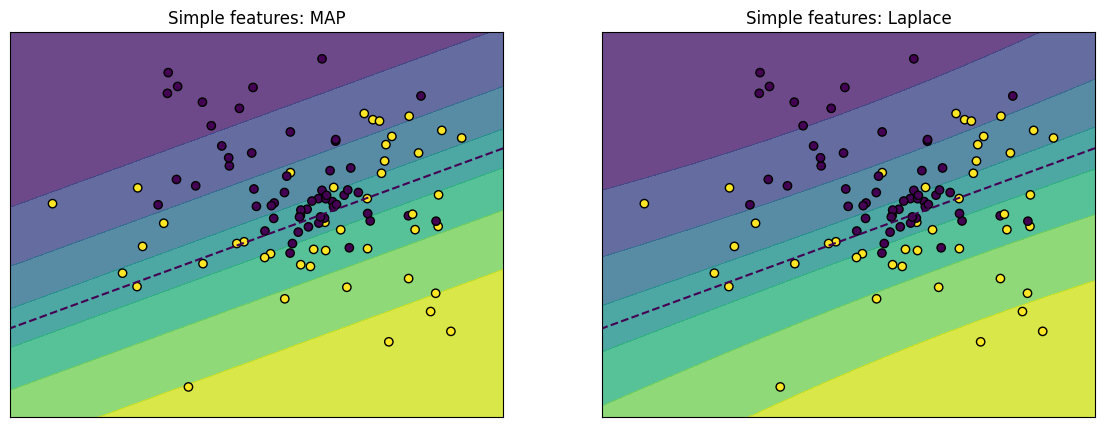

In [66]:
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.title("Simple features: MAP")
plot_boundary(X_train, y_train, 
              lambda X: predict_probs_MAP(features_simple(X), w_MAP_simple))

plt.subplot(122)
plt.title("Simple features: Laplace")
plot_boundary(X_train, y_train, 
              lambda X: predict_bayes(features_simple(X), w_MAP_simple, Cov_simple))

In [67]:
Cov_quad = compute_laplace_Cov(features_quadratic(X_train), y_train, w_MAP_quad)

C:\Users\44774\AppData\Local\Temp\ipykernel_26428\3616446327.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
C:\Users\44774\AppData\Local\Temp\ipykernel_26428\3616446327.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  np.arange(y_min, y_max, h))


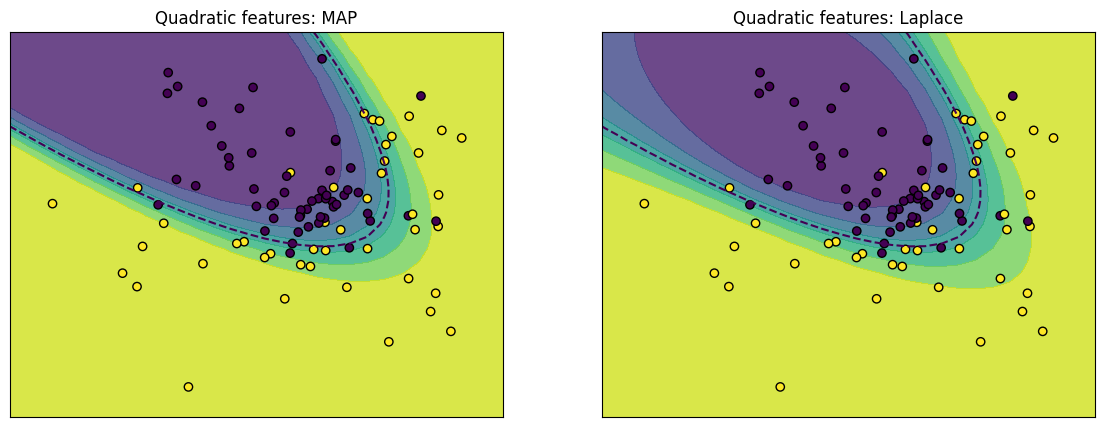

In [68]:
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.title("Quadratic features: MAP")
plot_boundary(X_train, y_train, 
              lambda X: predict_probs_MAP(features_quadratic(X), w_MAP_quad))

plt.subplot(122)
plt.title("Quadratic features: Laplace")
plot_boundary(X_train, y_train, 
              lambda X: predict_bayes(features_quadratic(X), w_MAP_quad, Cov_quad))

In [69]:
# (GRADING)

In [70]:
# (GRADING)

In [71]:
# (GRADING)

# TASK #4 (2 points): Model comparison

You can compute the marginal likelihood approximation defined by the Laplace approximation.

This estimate of the evidence can be used, even just looking at the training data, to help decide which of the two feature maps is more appropriate and better fits the data.

This can help guard against potential overfitting if using features that are "too complex".

In [85]:
def compute_laplace_log_evidence(Phi, y, w_MAP, Cov):
    """
    This computes the Laplace approximation to the marginal likelihood,
    as defined in the Week 5 lectures.
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones
    w_MAP : (D,) vector of optimized weights, at a mode of the target density
    Cov   : (D, D) approximate posterior covariance matrix
    
    OUTPUT:
    log_evidence : scalar value estimating `log p(y | Phi)`
    """

    # log likelihood at the MAP estimate
    y_hat = torch.sigmoid(Phi @ w_MAP)
    
    # construct a vector of probabilities for the observed data
    prob_y_vec = y * y_hat + (1 - y) * (1 - y_hat)
    
    # Compute the log joint probability at the MAP estimate
    log_joint_val = log_joint(Phi, y, w_MAP)
    
    # Compute the log determinant of the inverse of covariance matrix
    log_det_cov = torch.logdet(np.linalg.inv(Cov))
    
    # Compute the dimensionality of the weight vector
    D = Phi.size()[1]
    
    # Compute the log evidence using the Laplace approximation
    log_evidence = log_joint_val - log_det_cov / 2 + D / 2 * torch.log(torch.tensor(2 * torch.pi))
    
    return log_evidence

In [86]:
print("Model evidence estimate (simple features):",
      compute_laplace_log_evidence(features_simple(X_train), y_train, w_MAP_simple, Cov_simple).item())

print("Model evidence estimate (polynomial features):",
      compute_laplace_log_evidence(features_quadratic(X_train), y_train, w_MAP_quad, Cov_quad).item())

Model evidence estimate (simple features): -70.93084716796875
Model evidence estimate (polynomial features): -57.52272415161133


In [74]:
# (GRADING)

# TASK #5 (2 points + 4 points): Define your own feature space

Your next task is to define your own, custom feature space! This can be practically any deterministic function from $\mathbb{R}^2$ to $\mathbb{R}^D$, and you even get to pick the dimensionality $D$.

In the following cells, you first define your feature space, and then we estimate the posterior using your code above. We report training accuracy, test accuracy, and model evidence, as well as plot the decision boundaries.

Feel free to get quite creative here! However, you will be asked to defend your choice of feature space in the free-answer section at the bottom.

**Make sure when you submit, you include whatever you consider the "best" possible choice!**

In [75]:
def features_student(X):
    """
    Compute your own, custom set of features with only polynomial terms.
    
    INPUT:
    X      : (N, 2) tensor of raw input data
    
    OUTPUT:
    Phi    : (N, D) tensor of transformed inputs (polynomial feature space)
    """
    
    x1 = X[:, 0]
    x2 = X[:, 1]
    
    # Polynomial terms up to degree 3
    Phi = torch.cat((
        torch.ones_like(x1).unsqueeze(1),   # Bias term (intercept)
        x1.unsqueeze(1),                    # Linear term x1
        x2.unsqueeze(1),                    # Linear term x2
        (x1**2).unsqueeze(1),               # Quadratic term x1^2
        (x2**2).unsqueeze(1),               # Quadratic term x2^2
        (x1 * x2).unsqueeze(1),             # Interaction term x1 * x2
        (x1**3).unsqueeze(1),               # Cubic term x1^3
        (x2**3).unsqueeze(1),               # Cubic term x2^3
        (x1**2 * x2).unsqueeze(1)          # Interaction term x1^2 * x2
    ), dim=1)
    
    return Phi

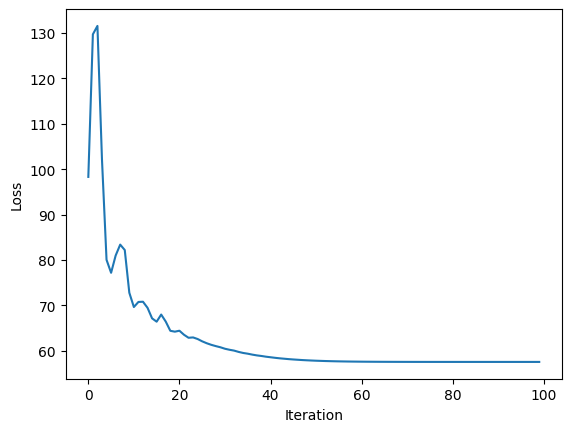

In [76]:
# Shows how loss decreases over 100 iterations as optimization algo updates the weights to find the MAP estimate.
w_MAP_student, losses = find_MAP(features_student(X_train), y_train)
plt.plot(losses);
plt.xlabel("Iteration")
plt.ylabel("Loss");

In [77]:
# Training and test accuracy
train_accuracy = (predict_probs_MAP(features_student(X_train), w_MAP_student).round() == y_train).float().mean()
test_accuracy = (predict_probs_MAP(features_student(X_test), w_MAP_student).round() == y_test).float().mean()
print("YOUR features! Training accuracy = %0.2f, test accuracy = %0.2f" % (train_accuracy, test_accuracy))

YOUR features! Training accuracy = 0.88, test accuracy = 0.92


In [78]:
# Model Evidence Estimate
Cov_student = compute_laplace_Cov(features_student(X_train), y_train, w_MAP_student)

print("YOUR features! Model evidence estimate:",
      compute_laplace_log_evidence(features_student(X_train), y_train, w_MAP_student, Cov_student).item())

YOUR features! Model evidence estimate: -54.001461029052734


In [79]:
# MAP Estimate
w_MAP_student

tensor([-2.9895,  2.6677,  0.7930,  1.1955,  3.6062,  2.9648, -0.7488, -3.3495,
        -1.0196])

C:\Users\44774\AppData\Local\Temp\ipykernel_26428\3616446327.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
C:\Users\44774\AppData\Local\Temp\ipykernel_26428\3616446327.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  np.arange(y_min, y_max, h))


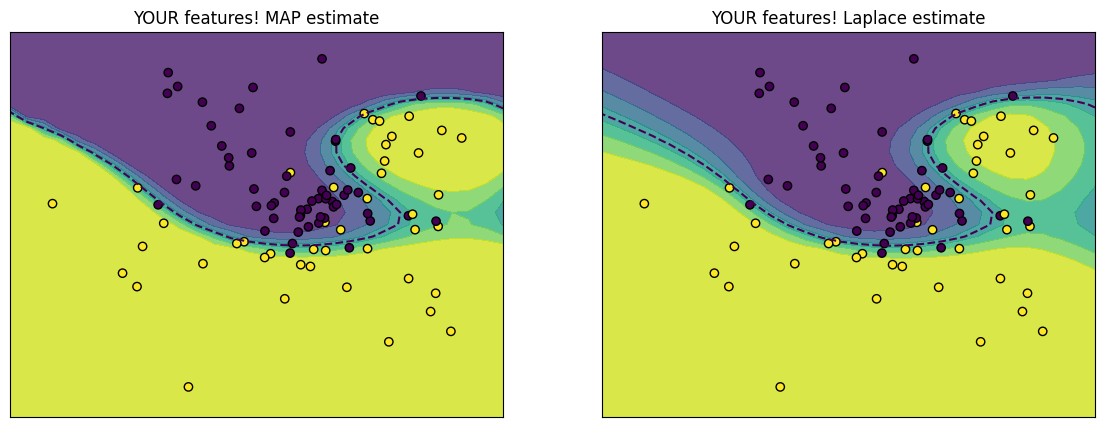

In [80]:
# Decision Boundary Plots
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.title("YOUR features! MAP estimate")
plot_boundary(X_train, y_train, 
              lambda X: predict_probs_MAP(features_student(X), w_MAP_student))

plt.subplot(122)
plt.title("YOUR features! Laplace estimate")
plot_boundary(X_train, y_train, 
              lambda X: predict_bayes(features_student(X), w_MAP_student, Cov_student))

# Please answer the following short questions:

1. *[Feature selection]* How did you choose your features? Name at least two ways of comparing whether one set of features is "better" than another. Would these methods generally yield the same "ranking" of different features? Why or why not?
2. *[Overfitting]* Is "overfitting" possible in this setting? Did you experience it? If so, how would you detect it? Does using the Laplace approximation "help" with overfitting, or does it not make a difference? Justify your answer.

### YOUR ANSWER
1. **Feature Selection**

   **a. Custom Feature Space Design**  
   I chose my custom features by expanding the original input features $x_1$ and $x_2$ into a richer polynomial space. Specifically:
   - I included **polynomial terms up to degree 3** to help capture non-linear relationships between the features.
   - I added **interaction terms** like $x_1 * x_2$ and $x_1^2 * x_2$ to capture potential interactions that may be relevant for classification.

   **b. Methods for Comparing Feature Sets**  
   Here are two common methods I used to determine whether my custom feature space is better than another:

   - **Model Evidence (Log Marginal Likelihood)**  
     - Use the model evidence, computed via the Laplace approximation, to evaluate how well the model explains the observed data while penalizing complexity.
     - A **higher model evidence** score indicates a more probable model under the Bayesian framework, balancing fit and complexity.

   - **Loss Plot Analysis**  
     - Compare feature sets by examining the **loss curves** generated during the optimization process.
     - The loss plot shows how the loss function decreases over iterations as the model parameters are optimized.
     - A **faster decrease** in loss (steeper drop) suggests that the model is easier to optimize and may be well-suited to the data.
     - A **lower final loss** indicates a better fit to the training data, though an excessively low loss may signal overfitting.

    **c. Methods Yielding Same Ranking**  
    These methods can yield different rankings of feature sets because they focus on different aspects of model performance:
    -  **Accuracy-Based Comparison**: This focuses solely on the predictive power of the model. A feature set that overfits the data might achieve high accuracy on the training set but perform poorly on the test set.
    - **Model Evidence Comparison**: This method penalizes complexity, so a simpler feature set with slightly lower accuracy but better generalization may be ranked higher.
    -  **Why?**: From **overfitting vs. generalization** perspective, accuracy alone does not account for the complexity of the model, so a more complex model may perform well on the training data but poorly on unseen data. Model evidence, on the other hand, incorporates a penalty for model complexity, leading to different rankings. Also given the **bias-variance tradeoff**, accuracy-based metrics may prefer models that reduce variance but increase bias, while model evidence seeks a balance between bias and variance.



2. **Overfitting** 

   **a. Definition of Overfitting**  
   Overfitting occurs when a model learns the noise in the training data instead of the underlying patterns. Usual pattern is high accuracy on the training set but poor generalization to unseen data.

   **b. Possibility of Overfitting in This Setting**  
   In this specific setting with polynomial features (up to degree 3) and interactions, overfitting is certainly possible because the model can be veery complicated, as polynomial terms create intricate decision boundaries especially in higher-degree terms. If the model is too complex relative to the amount of training data, it may fit the training data perfectly, leading to overfitting.

   **c. Use of Laplace Approximation**  
   The covariance matrix from the Laplace approximation captures the uncertainty in the weights as it considers the curvature of the posterior distribution, potentially leading to better generalization if the model is appropriately specified. However, it will not mitigate overfitting if the polynomial features are too high-dimensional or if the training data is insufficient.

#### Ignore the following cells. They are used by the grading system.

In [81]:
# (GRADING)

In [82]:
# (GRADING)